In [98]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import mplfinance as mpf


In [99]:
df=pd.read_csv("BTCUSDT_15m.csv")
df

,Timestamp,Open,High,Low,Close,Volume
0,1724513400000,63995.00,64069.00,63872.00,63952.97,186.08347
1,1724514300000,63952.97,63996.71,63909.99,63976.00,153.06990
2,1724515200000,63976.00,64094.00,63903.58,64000.86,272.31135
3,1724516100000,64000.86,64352.00,63977.71,64285.00,261.00600
4,1724517000000,64284.84,64413.01,64166.33,64194.99,339.76273
...,...,...,...,...,...,...
19995,1742508900000,84311.80,84369.57,83980.58,84012.08,195.17201
19996,1742509800000,84012.08,84159.51,84010.86,84124.80,119.11866
19997,1742510700000,84124.80,84311.33,84095.51,84141.31,95.63752
19998,1742511600000,84141.30,84150.00,84021.70,84045.49,97.86692


In [100]:
def detect_extreme_intact_swings(df, window=15):
    df['Swing_High'] = df['High'][(df['High'] == df['High'].rolling(window=window*2+1, center=True).max())]
    df['Swing_Low']  = df['Low'][(df['Low'] == df['Low'].rolling(window=window*2+1, center=True).min())]

    highs = df['Swing_High'].dropna()
    lows = df['Swing_Low'].dropna()

    # Initialisation des listes
    intact_highs, intact_lows = [], []

    # Traitement précis des swings High
    max_high = None
    for idx, price in highs.items():
        if max_high is None or price > max_high[1]:
            max_high = (idx, price)
        # Vérification liquidation du niveau précédent
        if max_high and df.loc[max_high[0]:]['High'].max() > max_high[1]:
            max_high = None
        elif max_high and (not intact_highs or max_high[1] != intact_highs[-1][1]):
            intact_highs.append(max_high)

    # Traitement précis des swings Low
    min_low = None
    for idx, price in lows.items():
        if min_low is None or price < min_low[1]:
            min_low = (idx, price)
        # Vérification liquidation du niveau précédent
        if min_low and df.loc[min_low[0]:]['Low'].min() < min_low[1]:
            min_low = None
        elif min_low and (not intact_lows or min_low[1] != intact_lows[-1][1]):
            intact_lows.append(min_low)

    return intact_highs, intact_lows


In [101]:
import mplfinance as mpf
from datetime import timedelta

# Application de la fonction améliorée
extreme_highs, extreme_lows = detect_extreme_intact_swings(df, window=15)

# Création des petits traits
alines, colors = [], []
trait_duration = timedelta(days=2)  # Petits traits courts (2 jours par exemple)

for date, price in extreme_highs:
    alines.append([(date, price), (date + trait_duration, price)])
    colors.append('red')

for date, price in extreme_lows:
    alines.append([(date, price), (date + trait_duration, price)])
    colors.append('blue')

# Visualisation définitive propre et nette
mpf.plot(df,
         type='candle',
         volume=True,
         style='charles',
         alines=dict(alines=alines, colors=colors, linewidths=2),
         title='BTC/USDT - Swings extrêmes intacts (petits traits propres)',
         figsize=(15,8))


TypeError: unsupported operand type(s) for +: 'int' and 'datetime.timedelta'

In [ ]:
def detect_relevant_swings(df, window=15, min_rejection=0.002):
    df['Swing_High'] = df['High'][(df['High'] == df['High'].rolling(window=window*2+1, center=True).max())]
    df['Swing_Low'] = df['Low'][(df['Low'] == df['Low'].rolling(window=window*2+1, center=True).min())]

    highs = df['Swing_High'].dropna()
    lows = df['Swing_Low'].dropna()

    relevant_highs, relevant_lows = [], []

    # Filtrer swings High pertinents
    for idx, price in highs.items():
        candle = df.loc[idx]
        rejection = candle['High'] - candle['Close']
        if rejection >= candle['High'] * min_rejection:
            if df.loc[idx:]['High'].max() <= price:
                relevant_highs.append((idx, price))

    # Filtrer swings Low pertinents
    for idx, price in lows.items():
        candle = df.loc[idx]
        rejection = candle['Close'] - candle['Low']
        if rejection >= candle['Low'] * min_rejection:
            if df.loc[idx:]['Low'].min() >= price:
                relevant_lows.append((idx, price))

    return relevant_highs, relevant_lows


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


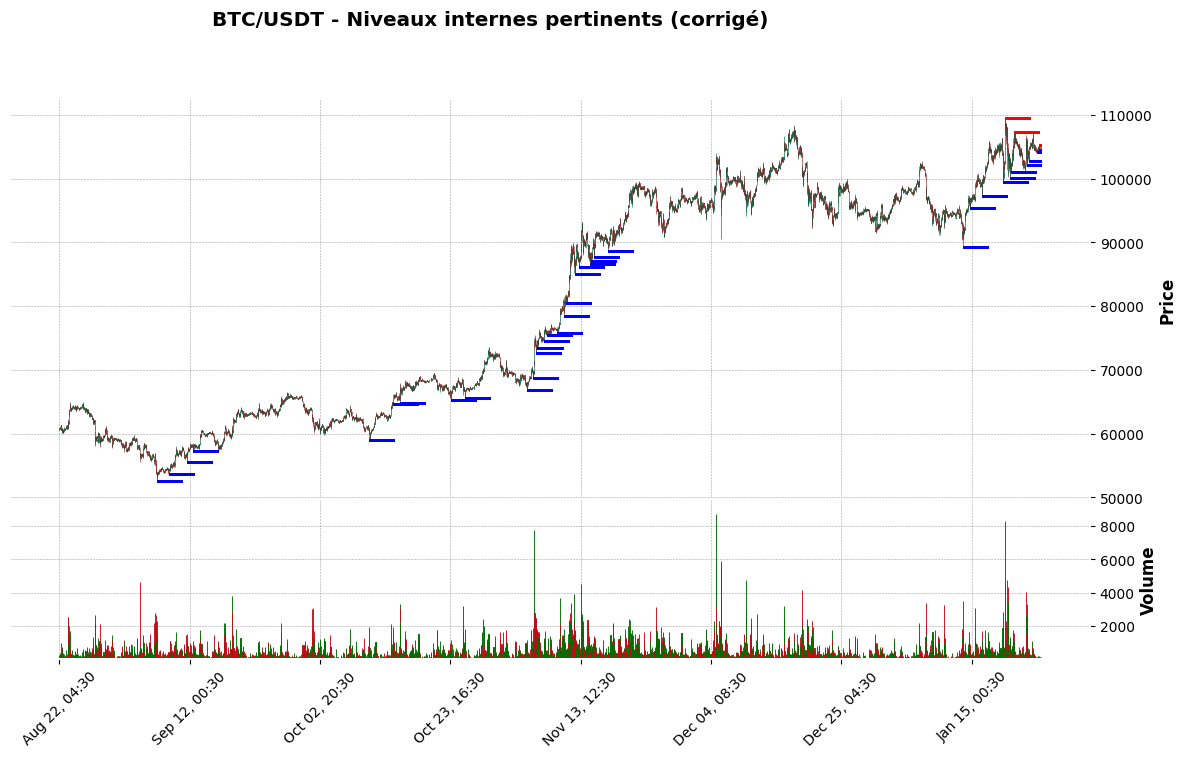

In [ ]:
import mplfinance as mpf
from datetime import timedelta

relevant_highs, relevant_lows = detect_relevant_swings(df, window=15, min_rejection=0.002)

alines, colors = [], []
trait_duration = timedelta(days=4)
max_date = df.index[-1]  # Date maximale du graphique

for date, price in relevant_highs:
    end_date = min(date + trait_duration, max_date)
    alines.append([(date, price), (end_date, price)])
    colors.append('red')

for date, price in relevant_lows:
    end_date = min(date + trait_duration, max_date)
    alines.append([(date, price), (end_date, price)])
    colors.append('blue')

# Graphique sans erreur désormais
mpf.plot(df,
         type='candle',
         volume=True,
         style='charles',
         alines=dict(alines=alines, colors=colors, linewidths=2),
         title='BTC/USDT - Niveaux internes pertinents (corrigé)',
         figsize=(15,8))


In [ ]:
def detect_relevant_swings_fibo(df, window=15, min_rejection=0.002):
    # Identifier swings hauts et bas
    df['Swing_High'] = df['High'][(df['High'] == df['High'].rolling(window=window*2+1, center=True).max())]
    df['Swing_Low'] = df['Low'][(df['Low'] == df['Low'].rolling(window=window*2+1, center=True).min())]

    highs = df['Swing_High'].dropna()
    lows = df['Swing_Low'].dropna()

    # Déterminer la plage de Fibonacci (le plus haut et le plus bas absolus)
    fib_high = highs.max()
    fib_low = lows.min()

    # Niveau médian (0.5 Fibonacci)
    fib_mid = (fib_high + fib_low) / 2

    relevant_highs, relevant_lows = [], []

    # Filtrer swings High (uniquement en zone Premium : au-dessus du mid)
    for idx, price in highs.items():
        if price >= fib_mid:
            candle = df.loc[idx]
            rejection = candle['High'] - candle['Close']
            if rejection >= candle['High'] * min_rejection:
                if df.loc[idx:]['High'].max() <= price:
                    relevant_highs.append((idx, price))

    # Filtrer swings Low (uniquement en zone Discount : en-dessous du mid)
    for idx, price in lows.items():
        if price <= fib_mid:
            candle = df.loc[idx]
            rejection = candle['Close'] - candle['Low']
            if rejection >= candle['Low'] * min_rejection:
                if df.loc[idx:]['Low'].min() >= price:
                    relevant_lows.append((idx, price))

    return relevant_highs, relevant_lows, fib_high, fib_low, fib_mid


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


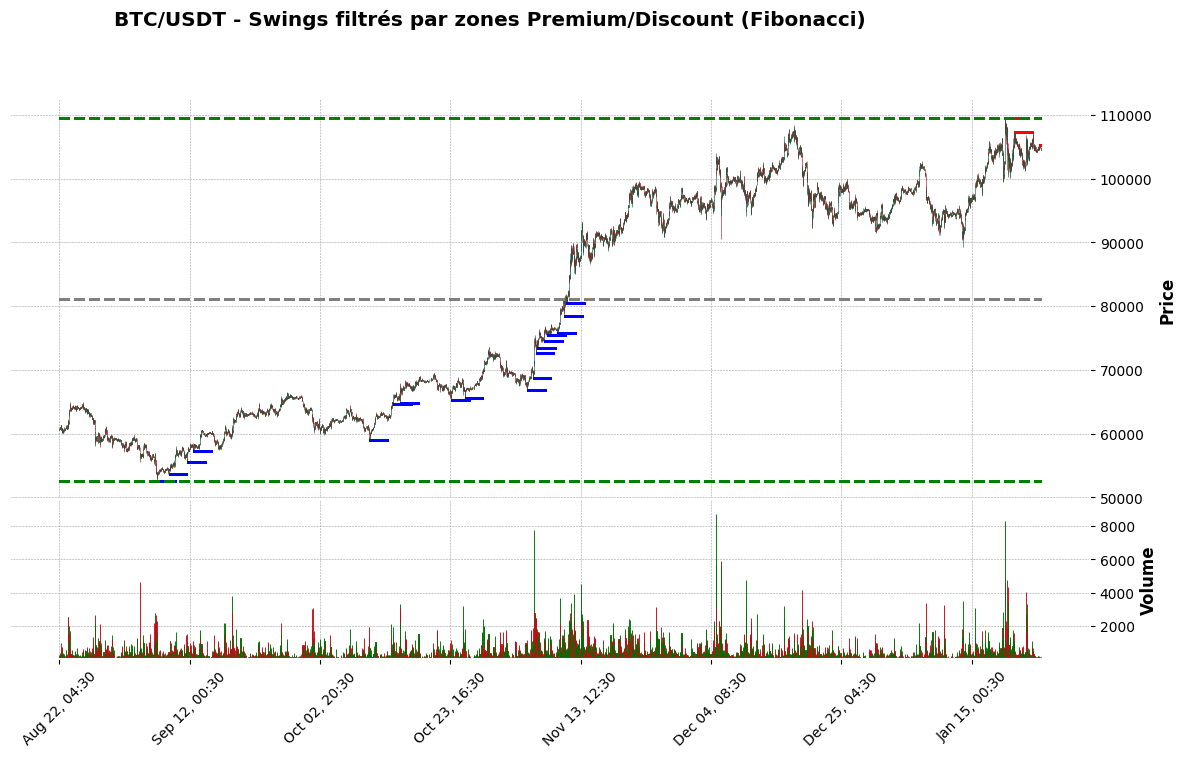

In [ ]:
import mplfinance as mpf
from datetime import timedelta

# Appliquer la nouvelle fonction avec filtre Fibonacci
relevant_highs, relevant_lows, fib_high, fib_low, fib_mid = detect_relevant_swings_fibo(df, window=15, min_rejection=0.002)

alines, colors = [], []
trait_duration = timedelta(days=3)
max_date = df.index[-1]

# Ajout des swings pertinents High (premium)
for date, price in relevant_highs:
    end_date = min(date + trait_duration, max_date)
    alines.append([(date, price), (end_date, price)])
    colors.append('red')

# Ajout des swings pertinents Low (discount)
for date, price in relevant_lows:
    end_date = min(date + trait_duration, max_date)
    alines.append([(date, price), (end_date, price)])
    colors.append('blue')

# Ajouter lignes Fibonacci clairement visibles
hline_levels = [fib_high, fib_mid, fib_low]
hline_colors = ['green', 'gray', 'green']

mpf.plot(df,
         type='candle',
         volume=True,
         style='charles',
         alines=dict(alines=alines, colors=colors, linewidths=2),
         hlines=dict(hlines=hline_levels, colors=hline_colors, linestyle='--'),
         title='BTC/USDT - Swings filtrés par zones Premium/Discount (Fibonacci)',
         figsize=(15,8))


In [ ]:
df = pd.read_csv("BTCUSDT_15m.csv")
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='ms')
df.set_index('Timestamp', inplace=True)


In [ ]:
import pandas as pd

def automatic_levels_until_end(df, candles_per_zone=1000):
    levels_high, levels_low = [], []
    last_high, last_low = None, None
    
    end_idx = len(df)

    while end_idx > 0:
        start_idx = end_idx - candles_per_zone
        if start_idx < 0:
            start_idx = 0  # Pour inclure les bougies restantes si moins de 20

        zone_df = df.iloc[start_idx:end_idx]

        zone_high = zone_df['High'].max()
        zone_low = zone_df['Low'].min()

        # Gestion automatique des points hauts (tendance)
        if last_high is None or zone_high >= last_high:
            last_high = zone_high
            levels_high.append((zone_df['High'].idxmax(), zone_high))
        elif zone_high < last_high:
            # Tendance baissière, garde le haut inférieur aussi
            levels_high.append((zone_df['High'].idxmax(), zone_high))
            last_high = zone_high

        # Gestion automatique des points bas (tendance)
        if last_low is None or zone_low <= last_low:
            last_low = zone_low
            levels_low.append((zone_df['Low'].idxmin(), zone_low))
        # Sinon, nouveau bas supérieur ignoré

        end_idx = start_idx  # Passage automatique à la zone précédente

    return levels_high, levels_low

# Exécution immédiate sur toutes tes données
levels_high, levels_low = automatic_levels_until_end(df, candles_per_zone=1000)

# Affichage clair des niveaux trouvés
print("Niveaux Hauts automatiques:", levels_high)
print("Niveaux Bas automatiques:", levels_low)


Niveaux Hauts automatiques: [(Timestamp('2025-03-20 00:00:00'), np.float64(87453.67)), (Timestamp('2025-03-02 17:45:00'), np.float64(95000.0)), (Timestamp('2025-02-21 13:45:00'), np.float64(99475.0)), (Timestamp('2025-02-07 14:45:00'), np.float64(100137.99)), (Timestamp('2025-01-30 15:00:00'), np.float64(106457.44)), (Timestamp('2025-01-20 06:45:00'), np.float64(109588.0)), (Timestamp('2025-01-17 10:30:00'), np.float64(102581.45)), (Timestamp('2025-01-07 00:30:00'), np.float64(102724.38)), (Timestamp('2024-12-17 14:45:00'), np.float64(108353.0)), (Timestamp('2024-12-16 18:30:00'), np.float64(107793.07)), (Timestamp('2024-12-05 03:00:00'), np.float64(104088.0)), (Timestamp('2024-11-22 19:30:00'), np.float64(99588.01)), (Timestamp('2024-11-13 16:15:00'), np.float64(93265.64)), (Timestamp('2024-10-29 19:00:00'), np.float64(73620.12)), (Timestamp('2024-10-21 00:30:00'), np.float64(69519.52)), (Timestamp('2024-10-15 14:00:00'), np.float64(67950.0)), (Timestamp('2024-09-27 14:30:00'), np.flo

In [119]:
import pandas as pd

# Conversion explicite et claire des données
df = pd.read_csv("BTCUSDT_15m.csv")
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='ms')
df.set_index('Timestamp', inplace=True)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


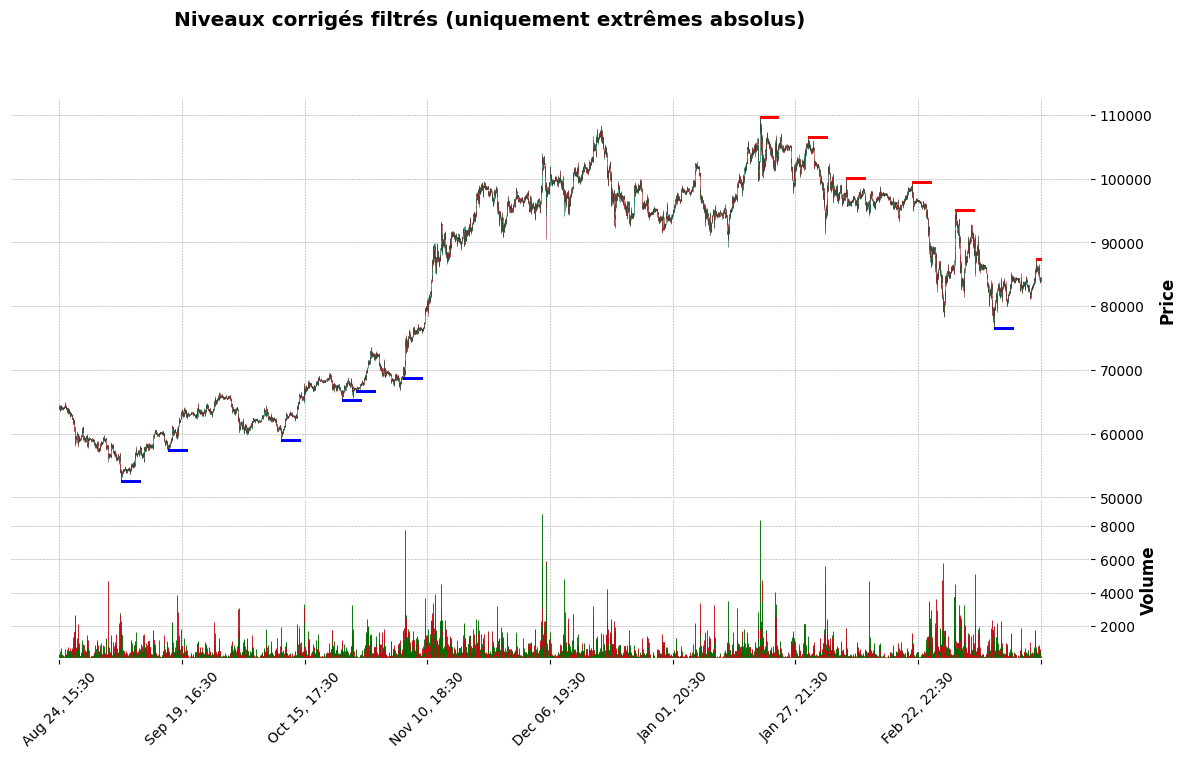

In [131]:
import pandas as pd

def automatic_filtered_levels(df, candles_per_zone=1000):
    levels_high, levels_low = [], []
    highest_level, lowest_level = None, None
    
    end_idx = len(df)

    while end_idx > 0:
        start_idx = max(end_idx - candles_per_zone, 0)
        zone_df = df.iloc[start_idx:end_idx]

        zone_high = zone_df['High'].max()
        zone_high_date = zone_df['High'].idxmax()

        zone_low = zone_df['Low'].min()
        zone_low_date = zone_df['Low'].idxmin()

        # Filtrage précis pour les hauts
        if (highest_level is None) or (zone_high > highest_level):
            highest_level = zone_high
            levels_high.append((zone_high_date, zone_high))

        # Filtrage précis pour les bas
        if (lowest_level is None) or (zone_low < lowest_level):
            lowest_level = zone_low
            levels_low.append((zone_low_date, zone_low))

        end_idx = start_idx  # zone précédente

    return levels_high, levels_low

# Exécution immédiate
levels_high, levels_low = automatic_filtered_levels(df, candles_per_zone=1000)
alines, colors = [], []
max_date = df.index[-1]

for date, price in levels_high:
    end_date = min(date + timedelta(days=4), max_date)
    alines.append([(date, price), (end_date, price)])
    colors.append('red')

for date, price in levels_low:
    end_date = min(date + timedelta(days=4), max_date)
    alines.append([(date, price), (end_date, price)])
    colors.append('blue')

mpf.plot(df,
         type='candle',
         style='charles',
         volume=True,
         alines=dict(alines=alines, colors=colors, linewidths=2),
         title='Niveaux corrigés filtrés (uniquement extrêmes absolus)',
         figsize=(15,8))



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


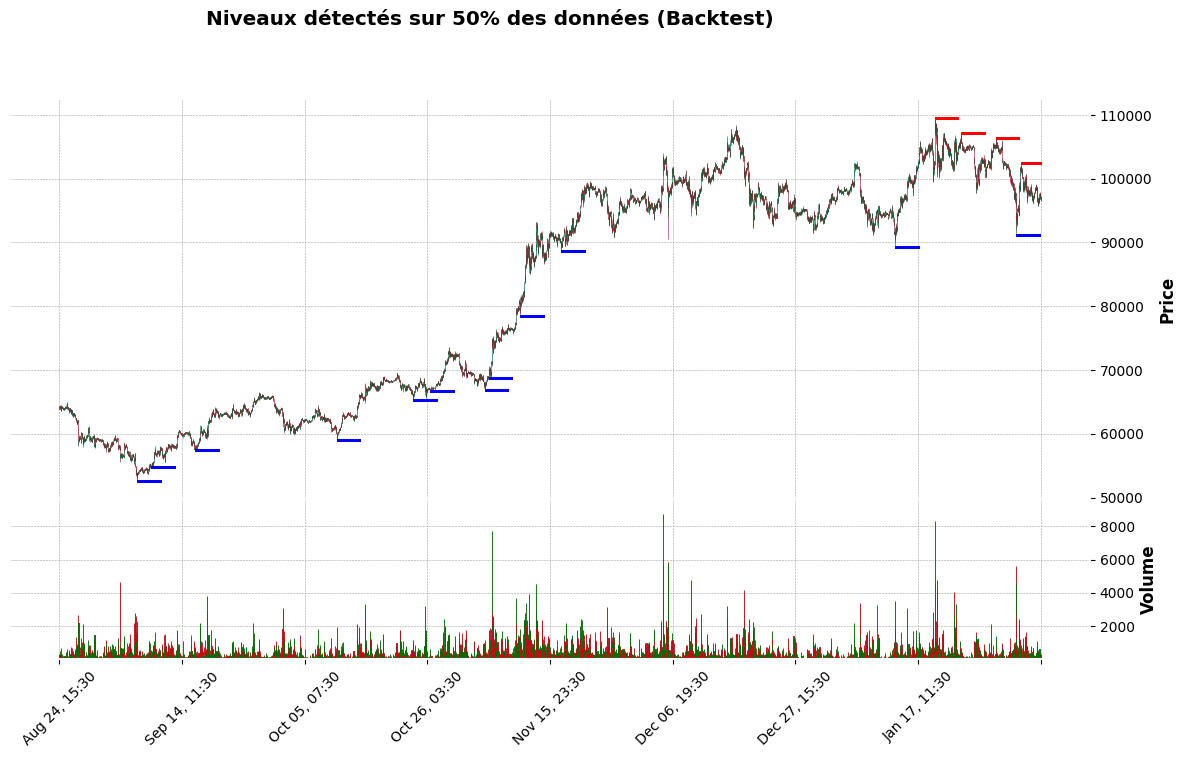

In [128]:
import pandas as pd
import mplfinance as mpf
from datetime import timedelta

# 📌 Chargement des données
df = pd.read_csv("BTCUSDT_15m.csv")

# 📌 Conversion du Timestamp
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='ms', errors='coerce')
df.set_index('Timestamp', inplace=True)
df.dropna(inplace=True)  # Suppression des valeurs corrompues

# 📌 Séparation en 50% Backtest / 50% Validation
split_index = int(len(df) * 0.8)
df_train = df.iloc[:split_index]  # 50% des données pour le backtest

# 📌 Algorithme de Détection des Niveaux
def automatic_filtered_levels(df, candles_per_zone=1000):
    levels_high, levels_low = [], []
    highest_level, lowest_level = None, None
    
    end_idx = len(df)

    while end_idx > 0:
        start_idx = max(end_idx - candles_per_zone, 0)
        zone_df = df.iloc[start_idx:end_idx]

        zone_high = zone_df['High'].max()
        zone_high_date = zone_df['High'].idxmax()

        zone_low = zone_df['Low'].min()
        zone_low_date = zone_df['Low'].idxmin()

        # 📌 Filtrage des niveaux pertinents
        if (highest_level is None) or (zone_high > highest_level):
            highest_level = zone_high
            levels_high.append((zone_high_date, zone_high))

        if (lowest_level is None) or (zone_low < lowest_level):
            lowest_level = zone_low
            levels_low.append((zone_low_date, zone_low))

        end_idx = start_idx  # On passe à la zone précédente

    return levels_high, levels_low

# 📌 Exécution de l'algorithme sur les 50% de données d'entraînement
levels_high_train, levels_low_train = automatic_filtered_levels(df_train, candles_per_zone=1000)

# 📌 Préparation pour la visualisation avec mplfinance
alines, colors = [], []
max_date = df_train.index[-1]

for date, price in levels_high_train:
    end_date = min(date + timedelta(days=4), max_date)
    alines.append([(date, price), (end_date, price)])
    colors.append('red')

for date, price in levels_low_train:
    end_date = min(date + timedelta(days=4), max_date)
    alines.append([(date, price), (end_date, price)])
    colors.append('blue')

# 📌 Visualisation des niveaux détectés sur les 50% de données d'entraînement
mpf.plot(df_train,
         type='candle',
         style='charles',
         volume=True,
         alines=dict(alines=alines, colors=colors, linewidths=2),
         title='Niveaux détectés sur 50% des données (Backtest)',
         figsize=(15,8))


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


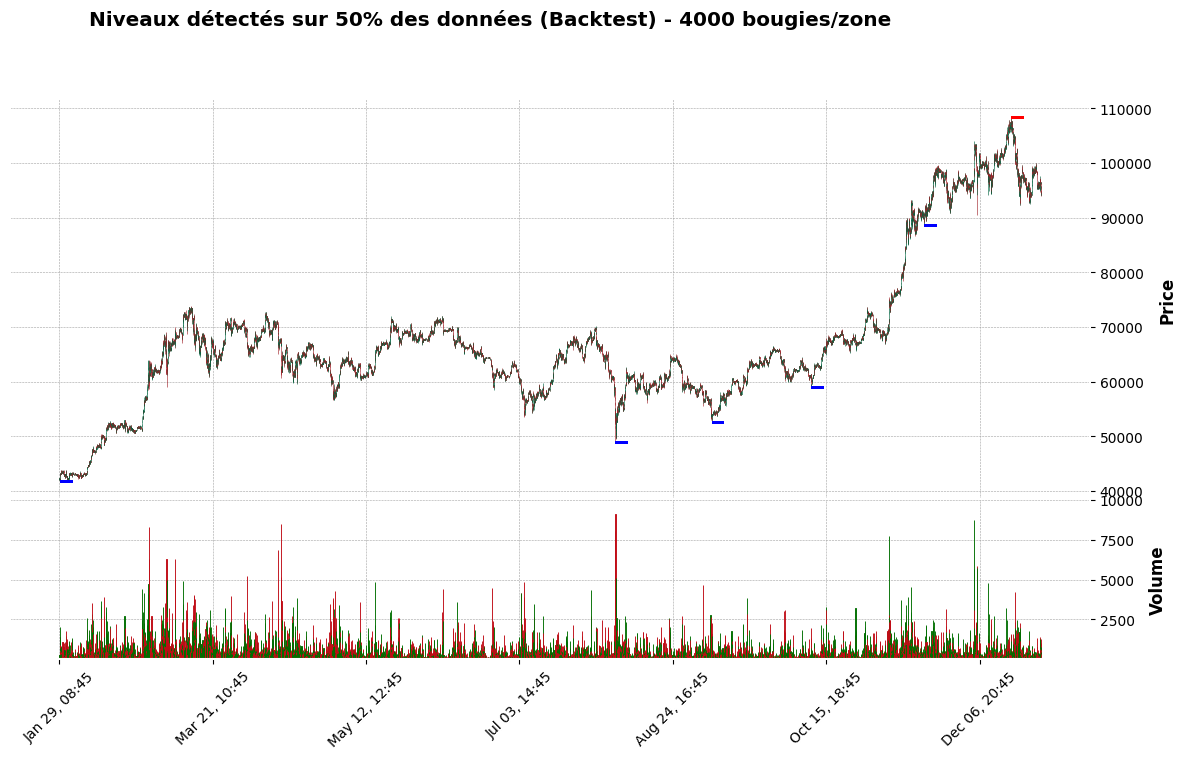

In [149]:
import pandas as pd
import mplfinance as mpf
from datetime import timedelta

# 📌 Chargement des données
df = pd.read_csv("BTCUSDT_15m.csv")

# 📌 Conversion du Timestamp
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='ms', errors='coerce')
df.set_index('Timestamp', inplace=True)
df.dropna(inplace=True)  # Suppression des valeurs corrompues

# 📌 Séparation en 50% Backtest / 50% Validation
split_index = int(len(df) * 0.8)
df_train = df.iloc[:split_index]  # 50% des données pour le backtest

# 📌 Ajustement dynamique : 1/5 ou 1/6 de la taille du CSV
candles_per_zone = max(50, min(len(df_train) // 7, len(df_train) // 8))  # Entre 1/5 et 1/6 du dataset

# 📌 Algorithme de Détection des Niveaux
def automatic_filtered_levels(df, candles_per_zone):
    levels_high, levels_low = [], []
    highest_level, lowest_level = None, None
    
    end_idx = len(df)

    while end_idx > 0:
        start_idx = max(end_idx - candles_per_zone, 0)
        zone_df = df.iloc[start_idx:end_idx]

        zone_high = zone_df['High'].max()
        zone_high_date = zone_df['High'].idxmax()

        zone_low = zone_df['Low'].min()
        zone_low_date = zone_df['Low'].idxmin()

        # 📌 Filtrage des niveaux pertinents
        if (highest_level is None) or (zone_high > highest_level):
            highest_level = zone_high
            levels_high.append((zone_high_date, zone_high))

        if (lowest_level is None) or (zone_low < lowest_level):
            lowest_level = zone_low
            levels_low.append((zone_low_date, zone_low))

        end_idx = start_idx  # On passe à la zone précédente

    return levels_high, levels_low

# 📌 Exécution de l'algorithme sur les 50% de données d'entraînement
levels_high_train, levels_low_train = automatic_filtered_levels(df_train, candles_per_zone)

# 📌 Préparation pour la visualisation avec mplfinance
alines, colors = [], []
max_date = df_train.index[-1]

for date, price in levels_high_train:
    end_date = min(date + timedelta(days=4), max_date)
    alines.append([(date, price), (end_date, price)])
    colors.append('red')

for date, price in levels_low_train:
    end_date = min(date + timedelta(days=4), max_date)
    alines.append([(date, price), (end_date, price)])
    colors.append('blue')

# 📌 Visualisation des niveaux détectés sur les 50% de données d'entraînement
mpf.plot(df_train,
         type='candle',
         style='charles',
         volume=True,
         alines=dict(alines=alines, colors=colors, linewidths=2),
         title=f'Niveaux détectés sur 50% des données (Backtest) - {candles_per_zone} bougies/zone',
         figsize=(15,8))


Total trades: 9
Total wins: 8
Total losses: 1
Winrate: 88.89%


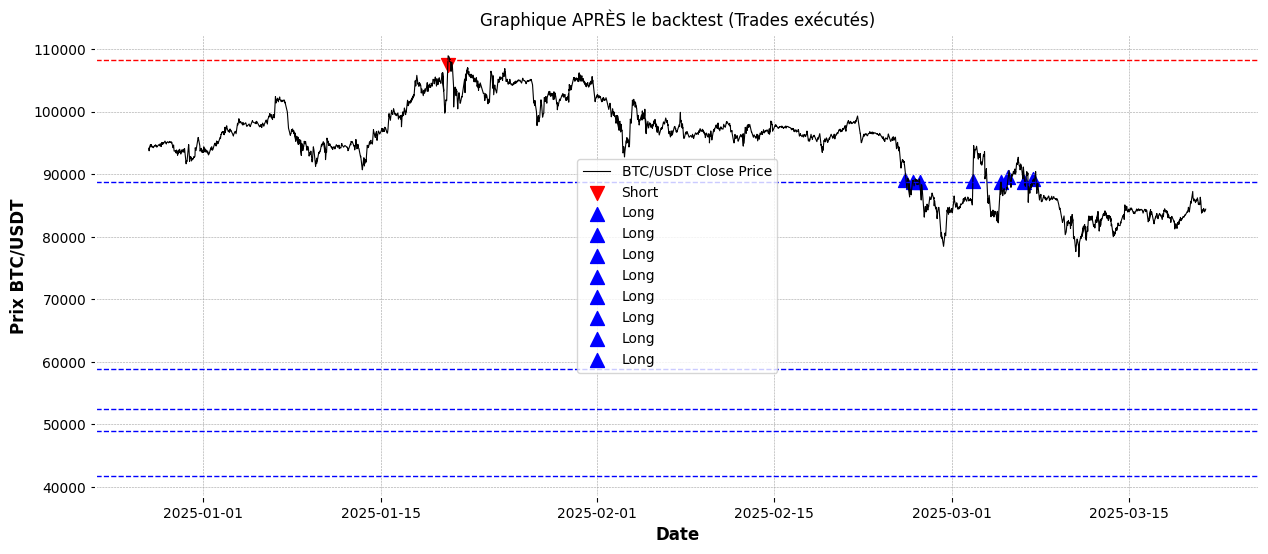

In [156]:
import pandas as pd
import mplfinance as mpf
import matplotlib.pyplot as plt
from datetime import timedelta

# 📌 Chargement des données
df = pd.read_csv("BTCUSDT_15m.csv")

# 📌 Conversion du Timestamp
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='ms', errors='coerce')
df.set_index('Timestamp', inplace=True)
df.dropna(inplace=True)  # Suppression des valeurs corrompues

# 📌 Séparation des données : 80% pour la détection, 20% pour le test live
split_index = int(len(df) * 0.8)
df_train = df.iloc[:split_index].copy()  # ✅ Sélection des 80% du dataset
df_test = df.iloc[split_index:].copy()  # ✅ Sélection des 20% du dataset

# 📌 Ajustement dynamique du nombre de bougies par zone
candles_per_zone = max(50, min(len(df_train) // 7, len(df_train) // 8))

# 📌 Détection des niveaux extrêmes sur 80% du dataset
def automatic_filtered_levels(df, candles_per_zone):
    levels_high, levels_low = [], []
    highest_level, lowest_level = None, None
    end_idx = len(df)

    while end_idx > 0:
        start_idx = max(end_idx - candles_per_zone, 0)
        zone_df = df.iloc[start_idx:end_idx]

        zone_high = zone_df['High'].max()
        zone_high_date = zone_df['High'].idxmax()

        zone_low = zone_df['Low'].min()
        zone_low_date = zone_df['Low'].idxmin()

        if (highest_level is None) or (zone_high > highest_level):
            highest_level = zone_high
            levels_high.append((zone_high_date, zone_high))

        if (lowest_level is None) or (zone_low < lowest_level):
            lowest_level = zone_low
            levels_low.append((zone_low_date, zone_low))

        end_idx = start_idx  

    return levels_high, levels_low

# 📌 Stockage des niveaux détectés sur les 80% des données
levels_high, levels_low = automatic_filtered_levels(df_train, candles_per_zone)

# 📌 Simulation du trading sur les 20% restants avec **FILTRAGE DES TRADES DUPLIQUÉS**
def simulate_trades(df_test, levels_high, levels_low, min_trade_distance=50):
    trades = []
    last_trade_high = None
    last_trade_low = None

    for idx, row in df_test.iterrows():
        for date, level in levels_high:
            if row['High'] >= level and (last_trade_high is None or (idx - last_trade_high).total_seconds() > min_trade_distance * 900):
                for jdx, reint_row in df_test.loc[idx:].iterrows():
                    if reint_row['Close'] < level:  # 📌 Réintégration confirmée
                        sl = reint_row['High'] + reint_row['High'] * 0.002  # SL = +0.2%
                        tp = reint_row['Close'] - (sl - reint_row['Close']) * 2  # TP = 2× SL
                        trades.append({'Type': "Short", 'Entry_Date': jdx, 'Entry': reint_row['Close'], 'SL': sl, 'TP': tp})
                        last_trade_high = jdx  # ✅ On enregistre la dernière entrée pour éviter les répétitions
                        break
                break  

        for date, level in levels_low:
            if row['Low'] <= level and (last_trade_low is None or (idx - last_trade_low).total_seconds() > min_trade_distance * 900):
                for jdx, reint_row in df_test.loc[idx:].iterrows():
                    if reint_row['Close'] > level:  # 📌 Réintégration confirmée
                        sl = reint_row['Low'] - reint_row['Low'] * 0.002  # SL = -0.2%
                        tp = reint_row['Close'] + (reint_row['Close'] - sl) * 2  # TP = 2× SL
                        trades.append({'Type': "Long", 'Entry_Date': jdx, 'Entry': reint_row['Close'], 'SL': sl, 'TP': tp})
                        last_trade_low = jdx  # ✅ On enregistre la dernière entrée pour éviter les répétitions
                        break
                break  

    return pd.DataFrame(trades)

# 📌 Exécution de la simulation avec **FILTRAGE des trades**
trades_results = simulate_trades(df_test, levels_high, levels_low)

# 📌 Vérification des résultats
if trades_results.empty:
    print("⚠️ Aucun trade détecté ! Vérifie les niveaux et la réintégration.")
else:
    total_trades = len(trades_results)
    total_wins = sum(trades_results['TP'] > trades_results['Entry'])
    total_losses = total_trades - total_wins
    winrate = (total_wins / total_trades) * 100 if total_trades > 0 else 0

    print(f"Total trades: {total_trades}")
    print(f"Total wins: {total_wins}")
    print(f"Total losses: {total_losses}")
    print(f"Winrate: {winrate:.2f}%")

# 📌 🎨 Visualisation des niveaux détectés + Trades exécutés
plt.figure(figsize=(15, 6))
plt.plot(df_test.index, df_test['Close'], label="BTC/USDT Close Price", color="black", linewidth=0.8)

# 🔴 Tracer les niveaux hauts détectés UNIQUEMENT dans df_train
for date, price in levels_high:
    if date in df_train.index:
        plt.axhline(y=price, color='red', linestyle='--', linewidth=1)

# 🔵 Tracer les niveaux bas détectés UNIQUEMENT dans df_train
for date, price in levels_low:
    if date in df_train.index:
        plt.axhline(y=price, color='blue', linestyle='--', linewidth=1)

# 🔽 Marquer les entrées en SHORT
for _, trade in trades_results[trades_results['Type'] == 'Short'].iterrows():
    plt.scatter(trade['Entry_Date'], trade['Entry'], color='red', marker='v', s=100, label="Short")

# 🔼 Marquer les entrées en LONG
for _, trade in trades_results[trades_results['Type'] == 'Long'].iterrows():
    plt.scatter(trade['Entry_Date'], trade['Entry'], color='blue', marker='^', s=100, label="Long")

plt.title("Graphique APRÈS le backtest (Trades exécutés)")
plt.xlabel("Date")
plt.ylabel("Prix BTC/USDT")
plt.legend()
plt.show()
